**Material parameters for Moresi el al (2014)**

This notebook outlines the material parameterisation used to model the dynamics of continental accretion as shown in Extended Data Figure 2 of [Moresi et al (2014) [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

In [1]:
import underworld as uw
from underworld import function as fn

import numpy as np
import math
import scipy
import scipy.special as special
import os
import matplotlib.pyplot as pypl
import pint

In [2]:
u = pint.UnitRegistry()

In [3]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.mpi.rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.mpi.barrier()

In [4]:
##Get Slab Parameters
# age       = 80 Myr oceanic lithosphere
# thickness = 7 km basaltic crust
# cohesion  = 12.5 MPa
# friction coeffient = 0.0666
# slabParams = calculateOceanicLayering(80, 7, cohesion = 12.5, frict = 0.0666, plot='plot')

**OK, Here's where I am. need to put this all in functions. ergh**

In [5]:
#def createMaterialProfile( maxDepth, layers, depth, rho, cohesion, friction, max_viscosity )

In [6]:
layer = []

In [7]:
## create numpy array with layer interfaces for depth
layers = np.array([0, 25, 50, 75, 100, 250]) * 10**3 * u.meter 
print('Numer of layers is {}'.format(len(layers)-1))
print('Interface at {}'.format(layers.to('kilometer')))

Numer of layers is 5
Interface at [   0.   25.   50.   75.  100.  250.] kilometer


In [8]:
res   = 251
depth = np.linspace(0, 250., res) * 10**3 * u.meter
rho   = np.empty(res) * u.kilogram / u.meter**3

In [9]:
# define density profile
crustDensity    = 2900 * u.kilogram / u.meter**3 # Oceanic crust (cold basalt)
mantleDensity   = 3400 * u.kilogram / u.meter**3  # (cold)  
for i, j in enumerate(depth):
    if j < 7.0 * 10**3 * u.meter:
        rho[i] = crustDensity # Oceanic crust (cold basalt)
    else:
        rho[i] = mantleDensity # (cold)  

In [10]:
# define yield criteria        
cohesion = 12.5 * 10**6 * u.pascal
friction = 0.0666

In [11]:
# parameters of interest!
Tsurf = 273.15 * u.degK
Tint  = 1573.0 * u.degK
kappa = 1e-6   * u.meter**2 / u.second 
alpha = 3.0e-5 / u.kelvin

grav  = 9.81   * u.meter / u.second**2
R     = 8.314  * u.joule / u.degK / u.mol

# wet diffusion creep - Karato & Wu, 1993
A = 5.3 * 10**15 / u.pascal / u.second
E = 240. * 10**3 * u.joule / u.mol
V = 5.0  * 1e-6 * u.meter**3 / u.mol

max_viscosity = 10**5

In [12]:
help(scipy)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
# for oceanic lithosphere thickness
def half_space_cooling(depth,age):
    return Tsurf +(Tint-Tsurf) * special.erf(depth/(2*np.sqrt(age*kappa)))

# age of oceanic lithosphere
age = 80. * 10**6 * u.year

# temperature profile of lithosphere
temperature = half_space_cooling(depth.to_base_units(), age.to_base_units())

In [14]:
# density profile of lithosphere
deltaT  = temperature - Tsurf
density = rho - rho * deltaT * alpha

In [15]:
# lithostatic pressure = \rho * g * h
pressure = density * grav * depth

In [16]:
def arrhenius(T,P):
    """ Arrhenius viscosity assuming absolute temperature T and pressure P """
    #print( E, V, P, R, T)
    # DW should be scaled to 'density' of crust or mantle, not just mantle?
    return np.exp((E + V*P)/(R*T))

In [17]:
# define some reference parameters
ref_depth     = 100. * 10**3 *u.meter   
ref_pressure  = mantleDensity * grav * ref_depth
ref_temp      = Tint
ref_viscosity = arrhenius(ref_temp, ref_pressure)
ref_density   = mantleDensity * (Tint-Tsurf) * alpha

In [18]:
# calculate viscosity profile
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 0, a_max = max_viscosity) 

In [19]:
# strength profiles
#     LayerWeakestStrength = [cohesion,0,0,0,0,0]
#     yieldStrength.append(cohesion)
#             yieldStrength.append(cohesion + frict * lithostaticPressure[index])
yieldStrength = cohesion + friction * pressure
        

In [20]:
# calculate averages of layers
avg_depth     = []
avg_temp      = []
avg_density   = []
avg_pressure  = []
avg_viscosity = []
avg_strength  = []
low_strength  = []

prevIndex = 0
for i, interface in enumerate(layers):
    if( interface > 250.*u.kilometer):
        break
    index = np.where(depth.magnitude==interface.magnitude)[0][0]
    if depth[index].magnitude > 0.:
        avg_depth.append(    np.average(depth.magnitude[prevIndex:index]))
        avg_temp.append(     np.average(temperature[prevIndex:index]))
        avg_density.append(( np.average(density[ prevIndex: index])-(density[-1]).magnitude)/ref_density.magnitude)
        avg_pressure.append( np.average(pressure.magnitude[prevIndex:index]))
        avg_viscosity.append(np.average(viscosity.magnitude[prevIndex:index]))
        avg_strength.append( np.average(yieldStrength.to('MPa').magnitude[prevIndex:index]))
        low_strength.append( np.min(yieldStrength.to('MPa').magnitude[prevIndex:index]))

    prevIndex = index

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [21]:
# yieldStrength.to('MPa').magnitude


<BarContainer object of 3 artists>

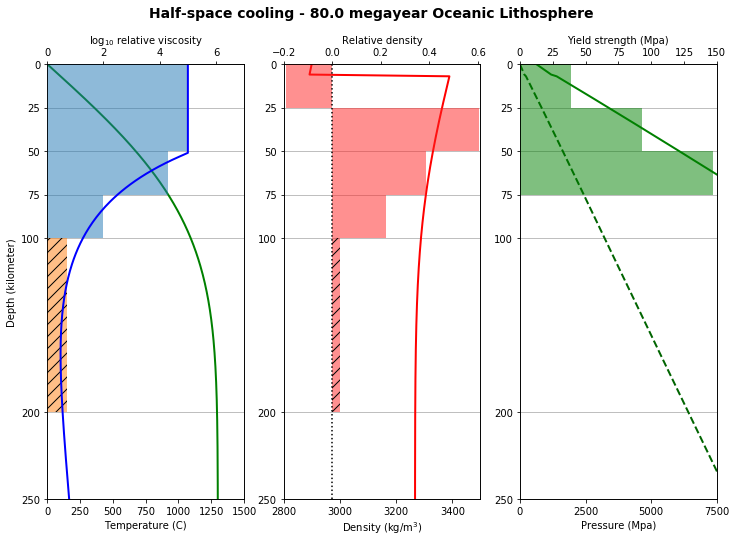

In [22]:
figure1 = pypl.figure(figsize=(12,8))

figure1.suptitle('Half-space cooling - {} Oceanic Lithosphere'.format(age.to('Myear')), fontsize=14, fontweight='bold')

# Temperature and Viscosity profiles
tempPlot = figure1.add_subplot(131)
tempPlot.plot(temperature.to('degC'), depth.to('kilometer'), color='green', linestyle='solid', linewidth=2, label='')
tempPlot.set_xlabel('Temperature (C)')
tempPlot.set_ylabel('Depth (kilometer)')
tempPlot.set_xlim(0,1500)
tempPlot.set_ylim(250, 0)
tempPlot.set_yticks([0,25,50,75,100,200,250])
tempPlot.grid(axis='y')

viscPlot = tempPlot.twiny()
viscPlot.plot(np.log10(viscosity), depth.to('kilometer'), color='blue', linestyle='solid', linewidth=2)
viscPlot.set_xlabel('log$_{10}$ relative viscosity')
viscPlot.set_xlim(0, 7)
viscPlot.set_ylim(0, 250)
viscPlot.invert_yaxis()
viscPlot.barh(layers.magnitude[0:4]/10**3,np.log10(avg_viscosity[0:4]), height=25.0, left=0.0, alpha=0.5, align="edge")
viscPlot.barh(100.0, np.log10(avg_viscosity[4]), height=100.0, left=0.0, alpha=0.5, linestyle='solid', hatch='//', align="edge")

# Density profile
densityPlot = figure1.add_subplot(132)
densityPlot.plot(density, depth.to('kilometer'), color='red' , linestyle='solid', linewidth=2)
densityPlot.set_xlabel('Density (kg/m$^3$)')
densityPlot.set_xlim(2800,3500)
densityPlot.set_ylim(0, 250)
densityPlot.invert_yaxis()
densityPlot.set_yticks([0,25,50,75,100,200,250])
densityPlot.grid(axis='y')

relDensityPlot = densityPlot.twiny()
relDensityPlot.set_xlabel('Relative density')
relDensityPlot.set_xlim(-0.2, 0.61)
relDensityPlot.axvline(x=0, ymin=0, ymax=1, linestyle='dotted', color='black')
relDensityPlot.set_ylim(250,0)
relDensityPlot.barh(layers[0:4]/10**3,avg_density[0:4], height=25.0, left=0.0, alpha=0.5, color='#FF2222', align="edge")
relDensityPlot.barh(100.0, avg_density[4], height=100.0, left=0.0, alpha=0.5, fill='false', color='#FF2222', hatch='//', align="edge")

# lithostatic pressure and strength profile
pressurePlot = figure1.add_subplot(133)
pressurePlot.set_xlabel('Pressure (Mpa)')
pressurePlot.set_yticks([0,25,50,75,100,200,250])
pressurePlot.plot(pressure.to('MPa'), depth.to('kilometer'), color='DarkGreen', linestyle='dashed', linewidth=2)
pressurePlot.set_xticks([0,2500,5000,7500,10000])
pressurePlot.set_ylim(0, 250)
pressurePlot.invert_yaxis()
pressurePlot.set_xlim(0, 7500)
pressurePlot.grid(axis='y')

strengthPlot = pressurePlot.twiny()
strengthPlot.set_xlabel('Yield strength (Mpa)')
strengthPlot.set_ylim(250,0)
strengthPlot.set_xlim(0, 150)
strengthPlot.plot(yieldStrength.to('MPa'), depth.to('kilometer'), color='green', linestyle='solid', linewidth=2, label='Yield strength (MPa)')

strengthPlot.barh(layers[0:3]/10**3,avg_strength[0:3], height=25.0, left=0.0, alpha=0.5, color='green', align="edge")
#strengthPlot.barh(LayerTop[0:4],LayerWeakestStrength[0:4], height=25.0, left=0.0, alpha=0.5, color='green', align="edge")
# strengthPlot.barh(100.0, LayerAverageStrength[4], height=100.0, left=0.0, alpha=0.5, color='#EEFFEE', linestyle='solid', hatch='//')


In [ ]:
# cratonic lithosphere, 
# thickness = 150 km thick
# crustal_thickness = 40km 
# density = 2700kg m^3
slabParams = calculateOceanicLayering(crust_thickness=40, plot='plot')  # densidy 

In [ ]:
# back-arc lithosphere, 
# thickness = 80 km
# crustal_thickness = 40km 
# density = 2800kg m^3
# cohesion  = 170 MPa
# friction coeffient = 0.0666

slabParams = calculateOceanicLayering(80, crust_thickness=40, plot='plot')  # densidy 

In [ ]:
# transition lithosphere, 
# thickness = 100 km
# crustal_thickness = 40km 
# density = 2700kg m^3
slabParams = calculateOceanicLayering(80, crust_thickness=40, plot='plot')  # densidy 

In [ ]:
# ribbon , 
# thickness = 50 km
# crustal_thickness = ?
# density = ?
slabParams = calculateOceanicLayering(80, crust_thickness=40, plot='plot')  # densidy 

In [ ]:
##Assign Material dictionaries

##Continental Values
CrustViscosity = 1.0*10**5
minCrustVisc = 1.0*10**3
CrustCohesion = 0.025
CrustDensity = -1.0

LithoViscosity = 4.0*10**2
minLithoVisc = 1.0*10**2
LithoCohesion = 0.05
LithoDensity = 0.1

#Geometry

trench = 2.5

slabGeo = {"minX":trench, "maxX": maxCoord[0]-0.25, "minZ":minCoord[2], "maxZ":maxCoord[2], "buoyantX":maxCoord[0]-0.5}
orpGeo = {"minX":minCoord[0]+0.25, "FAB":2.0, "maxX":trench, "minZ":minCoord[2], "maxZ": maxCoord[2]}
contPlatGeo = {"minX":trench + 1.5, "maxX": maxCoord[0]-1.0, "minZ": minCoord[2], "maxZ" : 2.0}

#MaterialProperties
##Space after HTML colour is needed to seperate colors until buoyant strip
## http://www.color-hex.com

upperMantle = {"Index": 0, "Density": 0.001, "Visc": 3.0, "color":"#00ffff "}
lowerMantle = {"Index": 1, "Density": 1.0, "Visc":100.0 , "color":"#ff0000 "} 

slabLayer1 = {"Index": 2, "Density": slabParams[1,3], "Density2": 1.0, "Visc":slabParams[1,2] , "minVisc":1.0*10**3,
              "Cohesion":0.01, "yeildRef": slabParams[1,4], "color":"#ffff00 "}
slabLayer2 = {"Index": 3, "Density": slabParams[2,3], "Visc":slabParams[2,2], "minVisc": 5.0*10**2, "Cohesion":0.05,
             "yeildRef": slabParams[2,4], "color":"#ffff7f "}
slabLayer3 = {"Index": 4, "Density": slabParams[3,3], "Visc":slabParams[3,2],"minVisc": 5.0*10**2, "Cohesion":0.2, 
             "yeildRef": slabParams[3,4], "color":"#ffffb2 "}
slabLayer4 = {"Index": 5, "Density": slabParams[4,3], "Visc":slabParams[4,2], "minVisc": 1.0*10**5,"Cohesion":1.0, 
             "yeildRef": slabParams[4,4], "color":"#ffffe5 "}

orpBACrust = {"Index": 6, "Density": CrustDensity, "Visc":CrustViscosity, "Cohesion":CrustCohesion,
              "minVisc":minCrustVisc,"color":"#1ab2ff "}
orpBALitho = {"Index": 7, "Density": LithoDensity, "Visc":LithoViscosity, "Cohesion":LithoCohesion,
              "minVisc":minLithoVisc, "color":"#005580 "}
orpFACrust = {"Index": 8, "Density": CrustDensity, "Visc":CrustViscosity, "Cohesion":CrustCohesion,
            "minVisc":minCrustVisc, "color":"#006080 "}
orpFALitho = {"Index": 9, "Density": LithoDensity, "Visc":LithoViscosity, "Cohesion":LithoCohesion, 
             "minVisc":minLithoVisc, "color":"#4dd2ff "}

buoyantStrip = {"Index": 10, "Density": CrustDensity, "Visc":CrustViscosity, "Cohesion":CrustCohesion,
    "minVisc":minCrustVisc , "color":"#00004d"}

contPlatCrust = {"Index": 11, "Density": CrustDensity, "Visc":CrustViscosity, "Cohesion":CrustCohesion,
              "minVisc":minCrustVisc,"color":"#1ab2ff "}
contPlatLitho = {"Index": 12, "Density": LithoDensity, "Visc":LithoViscosity, "Cohesion":LithoCohesion,
              "minVisc":minLithoVisc, "color":"#005580 "}


# **Allocate materials to particles**